In [33]:
# import libraries and check versions
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(f'tensorflow version: {tf.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'numpy version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')

# check tensorflow GPU device support
if len(tf.config.list_physical_devices('GPU')) > 0:
    print('GPU present')
else:
    print('GPU absent')

tensorflow version: 2.6.0
pandas version: 1.3.2
numpy version: 1.20.3
seaborn version: 0.11.2
GPU present


## Data Importing and Wrangling

In [2]:
# import dataset
import pickle
dataset = pickle.load(open('./datasets/RML2016.10a_dict.pkl', 'rb'), encoding='latin1')

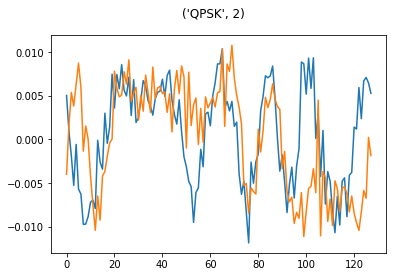

In [3]:
# plot dataset example
dataset_keys = list(dataset.keys())
x, y = dataset[dataset_keys[0]][1]

plt.figure(1)
plt.plot(x)
plt.plot(y)

plt.suptitle(dataset_keys[0])

plt.show()

In [4]:
# process raw data into usable format
columns = ['signal_type', 'SNR', 'samples']

# split dataset into individual records
temp = []
for k, v0 in dataset.items():
    data = [[k[0], k[1], v1] for v1 in v0]
    temp += data
    
# turn transformed data into dataframe
df = pd.DataFrame(temp, columns = columns)

# process dtypes of columns in dataframe
df = df.astype({'signal_type' : 'string'})

# filter out low SNR data
df = df[df['SNR'] >= 2]

print(df.info())
df.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99000 entries, 0 to 218999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   signal_type  99000 non-null  string
 1   SNR          99000 non-null  int64 
 2   samples      99000 non-null  object
dtypes: int64(1), object(1), string(1)
memory usage: 3.0+ MB
None


,signal_type,SNR,samples
0,QPSK,2,"[[-0.0059014712, -0.0023458179, -0.00074506126..."
1,QPSK,2,"[[0.0050326153, 0.00094379985, -0.0018932355, ..."
2,QPSK,2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0..."


## Data Preparation for Training

In [5]:
# generate signal tags for classification
signal_tags = {st : tag for tag, st in enumerate(sorted(df['signal_type'].unique()))}

tag_list = [signal_tags[i] for i in df['signal_type'].values]
df['tag'] = tag_list

df.head(3)

,signal_type,SNR,samples,tag
0,QPSK,2,"[[-0.0059014712, -0.0023458179, -0.00074506126...",9
1,QPSK,2,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",9
2,QPSK,2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",9


In [6]:
# extract 10 rows from each signal type for testing
df_train = df.copy()
df_test = pd.DataFrame([], columns = columns)

for st in df['signal_type'].unique():
    for snr in df['SNR'].unique():
        sample = df[df['signal_type'] == st][df['SNR'] == snr][:10]
        
        
        df_test = df_test.append(sample, ignore_index=True)        
        df_train.drop(sample.index.values, inplace=True)
        
df_test = df_test.astype({'tag' : 'int8'})

df_test.head(3)

/tmp/ipykernel_13353/70126845.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample = df[df['signal_type'] == st][df['SNR'] == snr][:10]


,signal_type,SNR,samples,tag
0,QPSK,2,"[[-0.0059014712, -0.0023458179, -0.00074506126...",9
1,QPSK,2,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",9
2,QPSK,2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",9


In [7]:
# scramble training dataset
df_train = df_train.sample(frac=1)

df_train.head(3)

,signal_type,SNR,samples,tag
218605,8PSK,6,"[[0.0051128813, 0.0042853234, 0.004498013, 0.0...",0
87254,AM-SSB,18,"[[-0.000942141, 0.0072381757, -0.00052559754, ...",2
122899,GFSK,14,"[[-0.006898954, -0.0064915013, -0.00594507, -0...",5


In [8]:
# define one hot encode function
def one_hot(arr, n_cat):
    output = []
    for n in arr:
        result = np.zeros(n_cat)
        result[n] = 1

        output.append(result)

    return np.array(output, dtype=int)

In [9]:
# extract train and test data
X_train = np.concatenate(df_train['samples'].values).reshape((df_train.shape[0], 2, 128, 1))
y_train = one_hot(df_train['tag'].values, 11)

X_test = np.concatenate(df_test['samples'].values).reshape((df_test.shape[0], 2, 128, 1))
y_test = one_hot(df_test['tag'].values, 11)

## Model Training and Testing

In [10]:
# import model stuff
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, concatenate, Dense, Input, Flatten

In [11]:
# functions for model segments
def res_unit(x, dim, n):
    '''
    function that creates a residual unit for each residual stack.

    INPUT PARAMETERS
    x: layer to connect to
    dim: size of layer
    n: number of units to create
    '''

    for _ in range(n):
        u = Conv2D(dim, 2, activation='relu', padding='same')(x)
        u = Conv2D(dim, 2, activation='linear', padding='same')(u)

        # skip-con
        x = concatenate([u, x])

    return x

def res_stack(x, dim):
    '''
    function that creates a residual stack for the model

    INPUT PARAMETERS
    x: layer to connect to
    dim: size of stack
    '''

    s = Conv2D(dim, 1, activation='linear', padding='same')(x)
    s = res_unit(s, dim, 2)
    s = MaxPooling2D(2, padding='same')(s)

    return s

In [12]:
# function to create main model
def create_model(in_dim, out_dim):
    '''
    function to construct the actual resnet model.

    INPUT PARAMETERS
    in_dim: dimensions of input
    out_dim: size of output
    '''

    input_layer = Input(in_dim)
    
    # res stacks
    x = res_stack(input_layer, 512)
    x = res_stack(x, 256)
    x = res_stack(x, 128)
    x = res_stack(x, 64)
    x = res_stack(x, 32)
    x = res_stack(x, 16)

    # fully connected layers
    x = Flatten()(x)
    x = Dense(128, activation='selu')(x)
    x = Dense(128, activation='selu')(x)

    output_layer = Dense(out_dim, activation='softmax')(x)

    # turn layers into model
    model = Model(inputs=input_layer, outputs=output_layer, name='resnet_rf_classification_model')

    return model

2021-10-05 16:40:53.631472: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-05 16:40:53.631935: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-05 16:40:53.632230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-05 16:40:53.632469: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

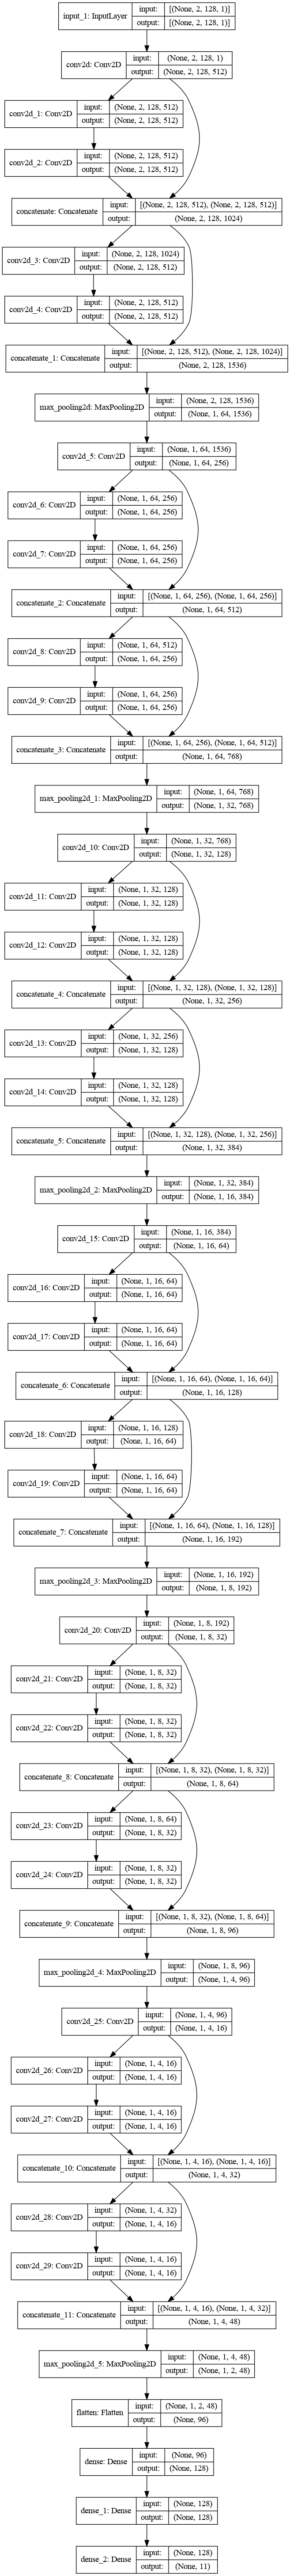

In [13]:
model = create_model((2, 128, 1), 11)

tf.keras.utils.plot_model(model, show_shapes=True)

In [14]:
# train model
# import metrics
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#early stopping
callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=50, callbacks=[callback], validation_split=0.2)

2021-10-05 16:40:54.435339: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-10-05 16:40:55.789384: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2021-10-05 16:40:56.440760: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-10-05 16:40:56.441177: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-10-05 16:40:56.441193: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2021-10-05 16:40:56.441583: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-10-05 16:40:56.441629: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-10-05 16:40:57.884029: I tensorflow/stream_executor/cuda/c

1569/1569 [==============================] - 91s 55ms/step - loss: 0.8998 - accuracy: 0.6112 - val_loss: 0.5553 - val_accuracy: 0.7302
Epoch 2/50
1569/1569 [==============================] - 86s 55ms/step - loss: 0.5261 - accuracy: 0.7526 - val_loss: 0.4368 - val_accuracy: 0.7717
Epoch 3/50
1569/1569 [==============================] - 86s 55ms/step - loss: 0.4060 - accuracy: 0.7956 - val_loss: 0.3716 - val_accuracy: 0.8034
Epoch 4/50
1569/1569 [==============================] - 86s 55ms/step - loss: 0.3564 - accuracy: 0.8146 - val_loss: 0.3387 - val_accuracy: 0.8197
Epoch 5/50
1569/1569 [==============================] - 86s 55ms/step - loss: 0.3433 - accuracy: 0.8230 - val_loss: 0.3642 - val_accuracy: 0.8041
Epoch 6/50
1569/1569 [==============================] - 86s 55ms/step - loss: 0.3083 - accuracy: 0.8340 - val_loss: 0.3208 - val_accuracy: 0.8326
Epoch 7/50
1569/1569 [==============================] - 86s 55ms/step - loss: 0.2975 - accuracy: 0.8406 - val_loss: 0.3000 - val_accura

In [36]:
# evaluate model performance on standard dataset
results = model.evaluate(X_test, y_test)

print(f'loss: {results[0]:.3f} | accuracy: {results[1]:.3f}')

31/31 [==============================] - 0s 11ms/step - loss: 0.3459 - accuracy: 0.8505
loss: 0.346 | accuracy: 0.851


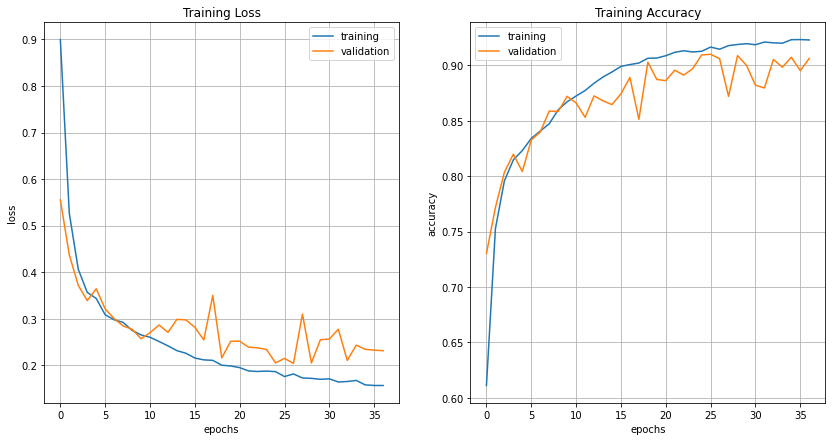

In [30]:
# plot out loss and accuracy graphs
train_hist = history.history

fig = plt.figure(1, figsize=(14, 7))

# loss graph
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(train_hist['loss'], label='training')
ax1.plot(train_hist['val_loss'], label='validation')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.set_title('Training Loss')
ax1.legend()
ax1.grid(b=True)

# accuracy graph
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(train_hist['accuracy'], label='training')
ax2.plot(train_hist['val_accuracy'], label='validation')
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')
ax2.set_title('Training Accuracy')
ax2.legend()
ax2.grid(b=True)

plt.show()

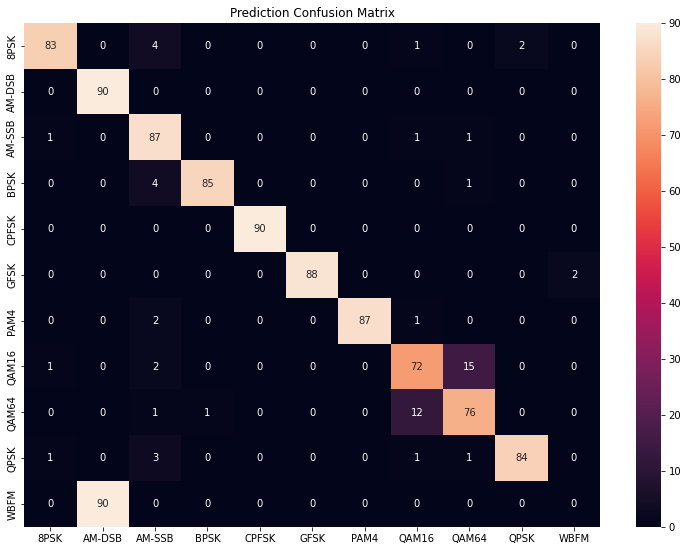

In [60]:
# plot confusion matrices
cm_pred = model.predict(X_test)

# process results
temp = []
for row in cm_pred:
    temp.append(np.argmax(row))  
cm_pred = np.array(temp)

cm_truth = df_test['tag'].values

# generate matrix
tags = list(signal_tags.keys())
df_cm = pd.DataFrame(tf.math.confusion_matrix(cm_truth, cm_pred).numpy(), index=tags, columns=tags)

# plot matrix
fig = plt.figure(2, figsize=(10, 7))
ax = fig.add_axes([1, 1, 1, 1])
sns.heatmap(df_cm, annot=True, fmt='d', ax=ax)
ax.set_title('Prediction Confusion Matrix')

plt.show()

In [61]:
# save model for future use
model.save('./saved_models/resnet_model')

2021-10-05 18:26:17.782996: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./saved_models/resnet_model/assets
